In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [9]:
def compile_multi_rep_file(num_reps:int=10, directory:str='E:\Ising_model_results_daai', var_name:str='fc_corr', subset:str='validation', num_nodes:int=21, num_epochs:int=200, p:str='0.019999999552965164', lr:str='0.001', threshold:str='0.1', start_index:int=0, end_index:int=None):
    if end_index == None:
        if subset == 'validation':
            end_index = 83
        else:
            end_index = 699
    pre_rep_string = os.path.join(directory, f'{var_name}_data_{subset}_nodes_{num_nodes}_')
    post_rep_string = f'_epochs_{num_epochs}_p_{p}_lr_{lr}_threshold_{threshold}_start_{start_index}_end_{end_index}.pt'
    first_file = f'{pre_rep_string}rep_0{post_rep_string}'
    first_values = torch.load(first_file)
    num_epochs, num_subjects = first_values.size()
    all_values = torch.zeros( (num_reps, num_epochs, num_subjects), dtype=float_type, device=device )
    all_values[0,:,:] = first_values
    for rep in range(1, num_reps):
        rep_file = f'{pre_rep_string}rep_{rep}{post_rep_string}'
        rep_values = torch.load(rep_file)
        all_values[rep,:,:] = rep_values
    all_file = f'{pre_rep_string}reps_{num_reps}{post_rep_string}'
    torch.save(all_values, all_file)
    all_values = all_values.transpose(dim0=-2, dim1=-1).flatten(start_dim=0, end_dim=-2)
    return all_file, all_values

In [10]:
def print_final_stats(name:str, values:torch.Tensor):
    last_values = values[:, -1]
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(last_values, quantile_cutoffs)
    min_val = torch.min(last_values)
    max_val = torch.max(last_values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [11]:
def boxplot_by_epoch(values:torch.Tensor, y_label:str, title:str, num_epochs_to_show:int = 40):
    num_epochs = values.size(dim=1)
    epoch_step = num_epochs//num_epochs_to_show
    sample_epochs = torch.arange(start=0, end=num_epochs_to_show*epoch_step, step=epoch_step, dtype=int_type, device=device).detach().cpu().numpy()
    sample_epochs[-1] = num_epochs-1# Make sure we get include the first and last epochs.
    # epoch_positions_np = torch.arange( sample_epochs.numel(), dtype=int_type, device=device ).cpu().detach().numpy()
    values_np = values[:,sample_epochs].detach().cpu().numpy()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    # axs.boxplot(values_np, positions=epoch_positions_np)
    axs.boxplot(values_np, positions=sample_epochs)
    axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel('epoch')
    axs.set_ylabel(y_label)
    axs.set_title(title)
    plt.show()

In [12]:
subset = 'training'
num_nodes = 21

In [13]:
corrs_file, corrs = compile_multi_rep_file(var_name='fc_corr', subset=subset, num_nodes=num_nodes)
print( corrs_file )
print( corrs.size() )

E:\Ising_model_results_daai\fc_corr_data_training_nodes_21_reps_10_epochs_200_p_0.019999999552965164_lr_0.001_threshold_0.1_start_0_end_699.pt
torch.Size([6690, 200])


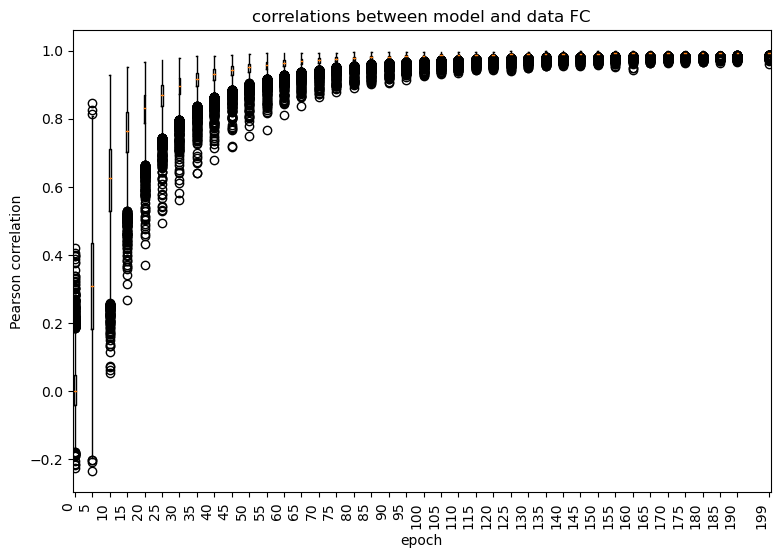

In [14]:
boxplot_by_epoch(values=corrs, y_label='Pearson correlation', title='correlations between model and data FC')

In [15]:
print_final_stats('FC correlation', corrs)

The distribution of FC correlation values has median 0.993 with 95% CI [0.985, 0.997] and range [0.96, 0.998].


In [16]:
rmses_file, rmses = compile_multi_rep_file(var_name='fc_rmse', subset=subset, num_nodes=num_nodes)
print( rmses_file )
print( rmses.size() )

E:\Ising_model_results_daai\fc_rmse_data_training_nodes_21_reps_10_epochs_200_p_0.019999999552965164_lr_0.001_threshold_0.1_start_0_end_699.pt
torch.Size([6690, 200])


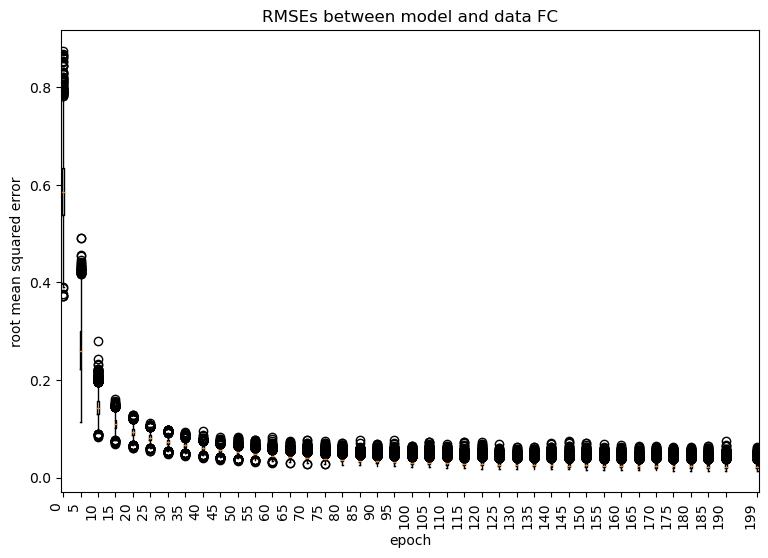

In [17]:
boxplot_by_epoch(values=rmses, y_label='root mean squared error', title='RMSEs between model and data FC')

In [18]:
print_final_stats('FC RMSE', rmses)

The distribution of FC RMSE values has median 0.0221 with 95% CI [0.0159, 0.0404] and range [0.0132, 0.0619].


In [20]:
def compile_multi_rep_J_file(num_reps:int=10, directory:str='E:\Ising_model_results_daai', var_name:str='J', subset:str='validation', num_nodes:int=21, num_epochs:int=200, p:str='0.019999999552965164', lr:str='0.001', threshold:str='0.1', start_index:int=0, end_index:int=None):
    if end_index == None:
        if subset == 'validation':
            end_index = 83
        else:
            end_index = 699
    pre_rep_string = os.path.join(directory, f'{var_name}_data_{subset}_nodes_{num_nodes}_')
    post_rep_string = f'_epochs_{num_epochs}_p_{p}_lr_{lr}_threshold_{threshold}_start_{start_index}_end_{end_index}.pt'
    first_file = f'{pre_rep_string}rep_0{post_rep_string}'
    first_values = torch.load(first_file)
    num_subjects, num_nodes_src, num_nodes_tgt = first_values.size()
    all_values = torch.zeros( (num_reps, num_subjects, num_nodes_src, num_nodes_tgt), dtype=float_type, device=device )
    all_values[0,:,:,:] = first_values
    for rep in range(1, num_reps):
        rep_file = f'{pre_rep_string}rep_{rep}{post_rep_string}'
        rep_values = torch.load(rep_file)
        all_values[rep,:,:,:] = rep_values
    all_file = f'{pre_rep_string}reps_{num_reps}{post_rep_string}'
    torch.save(all_values, all_file)
    return all_file, all_values

In [23]:
J_file, Js = compile_multi_rep_J_file(subset=subset, num_nodes=num_nodes)
print( J_file )
print( Js.size() )

E:\Ising_model_results_daai\J_data_validation_nodes_21_reps_10_epochs_200_p_0.019999999552965164_lr_0.001_threshold_0.1_start_0_end_83.pt
torch.Size([10, 83, 21, 21])


In [24]:
def compile_multi_rep_h_file(num_reps:int=10, directory:str='E:\Ising_model_results_daai', var_name:str='h', subset:str='validation', num_nodes:int=21, num_epochs:int=200, p:str='0.019999999552965164', lr:str='0.001', threshold:str='0.1', start_index:int=0, end_index:int=None):
    if end_index == None:
        if subset == 'validation':
            end_index = 83
        else:
            end_index = 699
    pre_rep_string = os.path.join(directory, f'{var_name}_data_{subset}_nodes_{num_nodes}_')
    post_rep_string = f'_epochs_{num_epochs}_p_{p}_lr_{lr}_threshold_{threshold}_start_{start_index}_end_{end_index}.pt'
    first_file = f'{pre_rep_string}rep_0{post_rep_string}'
    first_values = torch.load(first_file)
    num_subjects, num_nodes = first_values.size()
    all_values = torch.zeros( (num_reps, num_subjects, num_nodes), dtype=float_type, device=device )
    all_values[0,:,:] = first_values
    for rep in range(1, num_reps):
        rep_file = f'{pre_rep_string}rep_{rep}{post_rep_string}'
        rep_values = torch.load(rep_file)
        all_values[rep,:,:] = rep_values
    all_file = f'{pre_rep_string}reps_{num_reps}{post_rep_string}'
    torch.save(all_values, all_file)
    return all_file, all_values

In [27]:
subset = 'validation'
h_file, hs = compile_multi_rep_h_file(var_name='h', subset=subset, num_nodes=num_nodes)
print( h_file )
print( hs.size() )

E:\Ising_model_results_daai\h_data_validation_nodes_21_reps_10_epochs_200_p_0.019999999552965164_lr_0.001_threshold_0.1_start_0_end_83.pt
torch.Size([10, 83, 21])


In [28]:
# Load results from running Sida's code.
sida_output_file = os.path.join('C:\\Users\\agcraig\\Documents\\IsingModel','all_sims_rs.npy')
sims = np.load(sida_output_file)
print( np.shape(sims) )

(303, 50)


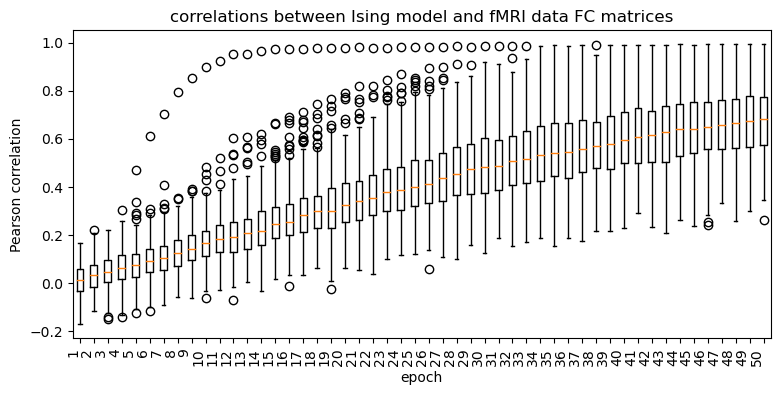

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.boxplot(sims)
# axs.boxplot(sims, positions=epoch_positions_np)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='right')
axs.set_title('correlations between Ising model and fMRI data FC matrices')
axs.set_xlabel('epoch')
axs.set_ylabel('Pearson correlation')
plt.show()

In [56]:
last_sims = sims[:,-1]
print( np.quantile(last_sims,quantile_cutoffs_list) )

[0.39635583 0.6800337  0.90174658]


In [57]:
print( np.min(last_sims), np.max(last_sims) )

0.26219672638677455 0.9939289207004971


Text(0.5, 1.0, 'comparison of distributions of model-data FC correlations')

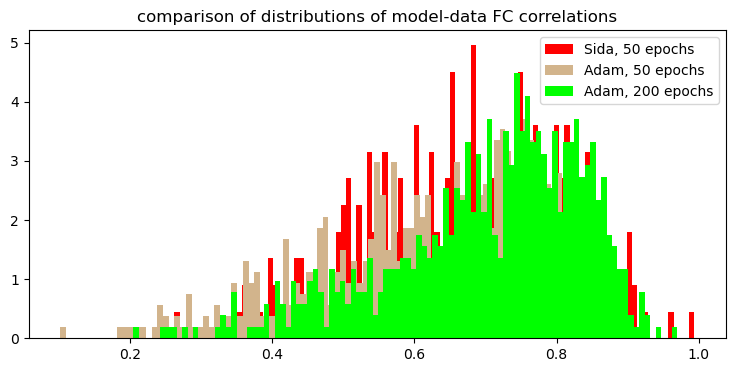

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
colors = ['red', 'tan', 'lime']
n_bins = 100
# axs.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
axs.hist(last_sims, n_bins, density=True, histtype='bar', color='red', label='Sida, 50 epochs')
mid_corrs_np = mid_corrs.detach().cpu().numpy()
axs.hist(mid_corrs_np, n_bins, density=True, histtype='bar', color='tan', label='Adam, 50 epochs')
last_corrs_np = last_corrs.detach().cpu().numpy()
axs.hist(last_corrs_np, n_bins, density=True, histtype='bar', color='lime', label='Adam, 200 epochs')
axs.legend(prop={'size': 10})
axs.set_title('comparison of distributions of model-data FC correlations')

In [66]:
from scipy import stats
ks_test_sida_vs_50 = stats.kstest(last_sims, mid_corrs_np)
print(ks_test_sida_vs_50)

KstestResult(statistic=0.09298064134771686, pvalue=0.05011232947067423, statistic_location=0.488099604845047, statistic_sign=-1)


In [68]:
ks_test_sida_vs_200 = stats.kstest(last_sims, last_corrs_np)
print(ks_test_sida_vs_200)

KstestResult(statistic=0.16065711048716813, pvalue=3.5439287153178864e-05, statistic_location=0.6871507848145262, statistic_sign=1)


In [69]:
ks_test_50_vs_200 = stats.kstest(mid_corrs_np, last_corrs_np)
print(ks_test_50_vs_200)

KstestResult(statistic=0.18507462686567164, pvalue=1.9238365407636352e-10, statistic_location=0.6221777, statistic_sign=1)
